# Table of Contents
* [Loading data](#Loading-data)
* [Looking at objects](#Looking-at-objects)
* [Looking at scenes](#Looking-at-scenes)
* [Looking at image complexity](#Looking-at-image-complexity)
* [Defining question object categories](#Defining-question-object-categories)
* [Displaying random image and questions](#Displaying-random-image-and-questions)
* [extacting bounding boxes from segmentation mask](#extacting-bounding-boxes-from-segmentation-mask)
* [hide](#hide)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
# %base16_mplrc light solarized
%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [3]:
import os
import itertools
import random
import cv2
import scipy.io as sio
import PIL.Image as Image

# Loading data

In [4]:
ade_matdata = sio.loadmat('./ADE20K_2016_07_26/index_ade20k.mat',  struct_as_record=False, squeeze_me=True)
ade_index = ade_matdata['index']

In [5]:
ade_index._fieldnames

['filename',
 'folder',
 'typeset',
 'objectIsPart',
 'objectPresence',
 'objectcounts',
 'objectnames',
 'proportionClassIsPart',
 'scene',
 'wordnet_found',
 'wordnet_level1',
 'wordnet_synset',
 'wordnet_hypernym',
 'wordnet_gloss',
 'wordnet_synonyms',
 'wordnet_frequency']

In [6]:
image_df = pd.DataFrame([ade_index.filename, ade_index.folder, ade_index.scene]).T
image_df.columns = ['filename', 'folder', 'scene']

In [10]:
obj_df = pd.DataFrame([ade_index.objectnames, ade_index.objectcounts, ade_index.proportionClassIsPart, ade_index.wordnet_found, ade_index.wordnet_level1, 
                       ade_index.wordnet_synset, ade_index.wordnet_hypernym, ade_index.wordnet_gloss, ade_index.wordnet_synonyms, ade_index.wordnet_frequency]).T
obj_df.columns = ['objectnames', 'objectcounts', 'proportionClassIsPart', 'wordnet_found',
 'wordnet_level1',
 'wordnet_synset',
 'wordnet_hypernym',
 'wordnet_gloss',
 'wordnet_synonyms',
 'wordnet_frequency']

img_obj_df = pd.DataFrame(ade_index.objectPresence).T
img_obj_df.index = image_df['filename']
img_obj_df.columns = obj_df['objectnames']

# Looking at objects

In [11]:
common_objects_df = obj_df[obj_df['objectcounts'] > 50]

In [12]:
common_objects_df['objectnames'].shape

(495,)

In [13]:
# _ = obj_df[obj_df['wordnet_frequency'] < 6000]['wordnet_frequency'].hist(bins = 60, log=True)

In [14]:
primary_obj_df = common_objects_df[common_objects_df['proportionClassIsPart'] == 0]

In [15]:
primary_obj_df['objectcounts'].sum() / obj_df['objectcounts'].sum()

0.4506219

In [16]:
primary_obj_df.shape

(305, 10)

In [17]:
short_names = {}
for name in primary_obj_df['objectnames']:
    split_names = name.split(',')
    for nc in split_names:
        if nc not in short_names.values():
            short_names[name] = nc.strip()
            break

In [18]:
len(short_names)

305

In [19]:
len(set(short_names.values()))

305

In [20]:
invert_short_names = {v:k for k,v in short_names.items()}

In [21]:
invert_short_names['tank']

'tank, storage tank'

In [22]:
# primary_obj_df.sort_values('objectcounts')

In [23]:
primary_obj_df['shortname'] = primary_obj_df['objectnames'].apply(lambda x: short_names[x])

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [24]:
# object_annotation_blank = pd.DataFrame(np.hstack((primary_obj_df['shortname'].values.reshape(primary_obj_df.shape[0], 1), np.zeros((primary_obj_df.shape[0], 5)))))
# object_annotation_blank.columns = ['shortname', 'metric', 'movable', 'set_on', 'container', 'liquid']

In [25]:
# object_annotation_blank.to_csv('object_annotaions.csv', index=False)

In [26]:
object_properties = pd.read_csv('./object_annotations.csv')

# Looking at scenes

In [65]:
coarse_scenes = set([sce.split('/')[0] for sce in ade_index.scene.tolist()])

In [66]:
indoor_words = ['indoor', 'interior', 'home', 'shop', 'office', 'hall', 'store']
outdoor_words = ['outdoor', 'exterior', 'forest', 'street', 'deck', 'garden', 'house', 'park', 'field', 'arena', 'farm', 'bridge']

scenes_by_type = defaultdict(set)
for scene in ade_index.scene.tolist():
    if set(indoor_words).intersection(set([item for sublist in [sc.split('_') for sc in scene.split('/')] for item in sublist])) or 'room' in scene:
        scenes_by_type['indoor'].add(scene)
    elif set(outdoor_words).intersection(set([item for sublist in [sc.split('_') for sc in scene.split('/')] for item in sublist])):
        scenes_by_type['outdoor'].add(scene)
    else:
        scenes_by_type['ambiguous'].add(scene)

In [67]:
for k, v in scenes_by_type.items():
    print(k, len(v))

outdoor 177
indoor 226
ambiguous 469


In [68]:
scene_assignments = {}
for stype, scene_cats in scenes_by_type.items():
    for scene_cat in scene_cats:
        scene_assignments[scene_cat] = stype

In [69]:
image_df['setting'] = image_df['scene'].apply(lambda x: scene_assignments[x])

In [70]:
in_out_counts = defaultdict(int)
for scene in ade_index.scene.tolist():
    in_out_counts[scene_assignments[scene]] += 1

In [71]:
in_out_counts

defaultdict(int, {'ambiguous': 10805, 'indoor': 7028, 'outdoor': 4377})

In [72]:
word_pieces = []
for scene in scenes_by_type['ambiguous']:
    word_pieces.extend([item for sublist in [sc.split('_') for sc in scene.split('/')] for item in sublist])

# Looking at image complexity

In [63]:
obj_counts = img_obj_df.sum(axis=1)

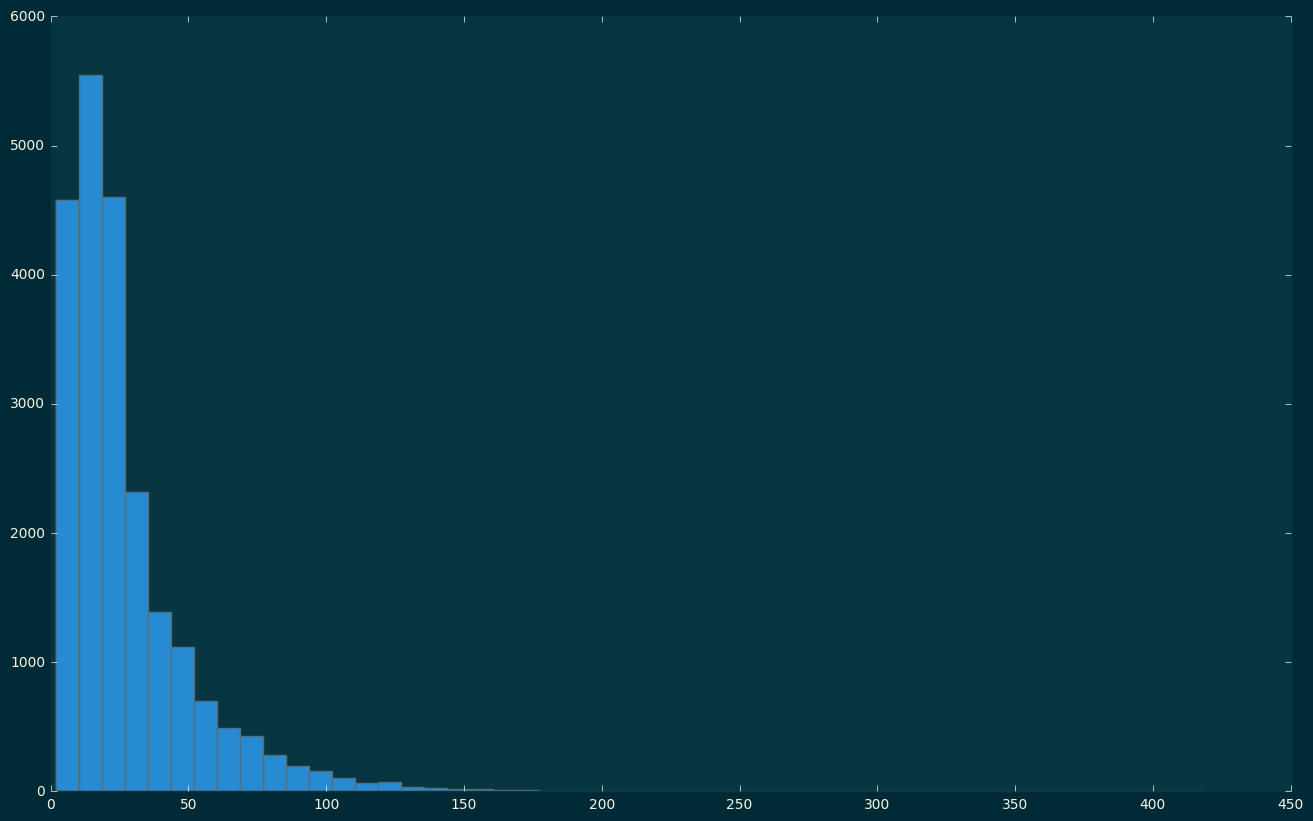

In [64]:
_ = obj_counts.hist(bins=50)

# Defining question object categories

In [53]:
q_cat_defs = {
    'vol_cats': ['glass, drinking glass', 'mug', 'bowl', 'bottle', 'box', 'bucket, pail', 'can, tin, tin can', 'container', 'jar'],
    'openable_cats': ['chest of drawers, chest, bureau, dresser', 'cabinet'],
    'surface_cats': ['coffee table, cocktail table', 'bench', 'counter', 'countertop', 'shelf', 'table']
    }

In [54]:
tot_objs = obj_df['objectcounts'].sum()

In [55]:
image_obj_dict = img_obj_df.to_dict(orient='index')

In [56]:
primary_objs = set(primary_obj_df['shortname'].tolist())

In [57]:
# object_properties.index = object_properties['shortname']
# del object_properties['shortname']

In [58]:
obj_prop_lookup = defaultdict(list)
for ob_name, objs in object_properties.to_dict(orient='index').items():
    for prop_type, sel in objs.items():
        if sel:
            obj_prop_lookup[ob_name].append(prop_type)

In [59]:
image_obj_cat_counts = defaultdict(lambda: defaultdict(int))
for img_n, objs in image_obj_dict.items():
    for obj, count in objs.items():
        if not count:
            continue
        elif obj in primary_objs:
            obj_props = obj_prop_lookup[obj]
            for prop in obj_props:
                image_obj_cat_counts[img_n][prop] += count

In [33]:
from math import factorial

In [34]:
def n_choose_2(n):
    if n < 2:
        return 0
    else:
        return factorial(n) / (2 * factorial(n - 2))

In [35]:
question_expectations = defaultdict(int)

for img_n, type_counts in image_obj_cat_counts.items():
    if 'metric' in type_counts:
        question_expectations['geometry_metric'] += n_choose_2(type_counts['metric'])
    if 'movable' in type_counts:
        question_expectations['movable'] += type_counts['movable']
    if 'set_on' in type_counts:
        question_expectations['set_on'] += type_counts['set_on']
    if 'container' in type_counts:
        question_expectations['container'] += n_choose_2(type_counts['metric'])
    if 'liquid' in type_counts:
        question_expectations['liquid'] += type_counts['liquid'] 

In [60]:
q_est_df = pd.DataFrame(question_expectations, index=[0]).T
q_est_df.columns = ['raw_estimate']
q_est_df['scaled'] = q_est_df['raw_estimate']

q_est_df['scaled'] = q_est_df['scaled']

q_est_df.filter(like='geo', axis=0)['scaled'] = q_est_df.filter(like='geo', axis=0)['scaled'] * 0.1

q_est_df.ix[q_est_df.index=='geometry_metric', 'scaled'] = q_est_df.ix[q_est_df.index=='geometry_metric', 'scaled'] / 100
q_est_df.ix[q_est_df.index=='container', 'scaled'] = q_est_df.ix[q_est_df.index=='container', 'scaled'] / 100

# Displaying random image and questions

In [39]:
def scene_selection_filter(scene):
    return

In [40]:
def object_selection_filter(image_name):
    conditions_met = False
    return conditions_met

In [41]:
def get_ade_image(image_df, ade_pre = '.', setting=None, obj_categories=None):
    global img_n
    found = False
    while not found:
        img_row_to_load = np.random.randint(0, image_df.shape[0])
        img_n = img_row_to_load
        image_path = os.path.join(ade_pre, image_df.iloc[img_row_to_load]['folder'], image_df.iloc[img_row_to_load]['filename'])
        mask_path = os.path.join(ade_pre, image_df.iloc[img_row_to_load]['folder'], image_df.iloc[img_row_to_load]['filename'].replace('.jpg', '_seg.png')) 
        img_to_disp = Image.open(image_path)
        mask = Image.open(mask_path)
        if not setting:
            found = 'True'
        elif image_df.iloc[img_row_to_load]['setting'] == setting:
            found = 'True'
        else:
            pass
    return img_to_disp, mask

In [43]:
# raw_image, mask_p1 = get_ade_image(image_df, setting='indoor')

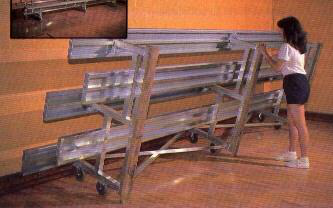

In [78]:
raw_image

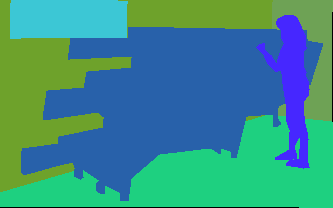

In [79]:
mask_p1

In [80]:
mask_array = np.array(list(mask_p1.getdata()))

In [82]:
test_image_df = img_obj_df.iloc[img_n][img_obj_df.iloc[img_n] != 0]

In [83]:
test_image_df

objectnames
floor, flooring                                        1.0
grandstand, covered stand                              1.0
painting, picture                                      1.0
person, individual, someone, somebody, mortal, soul    1.0
wall                                                   2.0
Name: ADE_train_00004314.jpg, dtype: float32

In [84]:
test_image_objects = img_obj_df.iloc[img_n][img_obj_df.iloc[img_n] != 0].index.tolist()
pruned_test_image_objects = [ob.split(',')[0] for ob in test_image_objects]
object_combos = list(itertools.combinations(pruned_test_image_objects, 2))

for objcts in random.sample(object_combos, 5):
    print('How far is the {} from the {}?'.format(*objcts))

How far is the floor from the wall?
How far is the painting from the person?
How far is the grandstand from the painting?
How far is the person from the wall?
How far is the grandstand from the person?


In [73]:
dynamics_templates = {
    '1_moves_how': 'If the force shown is applied to the {}, how will it move?',
    '1_moves_where': 'If the force shown is applied to the {}, where will it end up?',
    '1_apply_to_move': 'If we want the {} to end up in the region shown, how should we apply a force?'
}

statics_templates = {
    '2_hypo_removal': '',
    '1_apply_to_tip': '',
    '1_apply_to_fall': ''
}

metrics_templates = {
    '2_dist_between': 'How far is the {} from the {}?',
    '1_farthest_from': 'What is the farthest object from the {}?',
    '1_closest_to': 'What is the closest object to the {}?',
    '3_maximize_seperation': 'Where should the {} be moved such that is equally far from the {} and the {}'
}

volume_templates ={
    '2_can_fit': 'Can the {} fit inside the {}?',
    '1_largest_fit': 'What is the largest object in the scene that will fit inside the {}?',
    '2_how_many_fit': 'How many of the {} could fit inside the {}?'
}

liquid_templates = {
    '2_can_liquid_fit': 'Can the {} hold the liquid contained in the {}?',
    '1_est_volums': 'How much liquid could the {} hold?',
}

# Extacting bounding boxes from segmentation mask

In [45]:
test_image_path = '/Users/schwenk/wrk/pqa/ade20k/ADE20K_2016_07_26/images/training/c/computer_room/'
test_image = Image.open(test_image_path + 'ADE_train_00005940.jpg')
test_mask = Image.open(test_image_path + 'ADE_train_00005940_seg.png')
cv_mask = cv2.imread(test_image_path + 'ADE_train_00005940_seg.png')

In [47]:
# Image.fromarray(cv_mask[::,::,::-1])

In [48]:
# pd.value_counts(r_chan.flatten())
# pd.value_counts(g_chan.flatten())
# pd.value_counts(b_chan.flatten())

In [170]:
b_chan.shape

(1000, 1500, 2)

In [49]:
sorted(pd.Series(b_chan.flatten()).value_counts().index.tolist())

[0,
 6,
 12,
 17,
 23,
 29,
 35,
 41,
 46,
 52,
 58,
 64,
 70,
 75,
 81,
 87,
 93,
 99,
 104,
 110,
 116,
 122,
 128,
 133,
 139,
 145,
 151,
 156,
 162,
 168,
 174,
 180,
 185,
 191,
 197,
 203,
 209,
 214,
 220,
 226,
 232,
 238,
 243,
 249,
 255]

In [50]:
len(sorted(pd.Series(b_chan.flatten()).value_counts().index.tolist()))

45

In [76]:
obj_df['obj_class'] = obj_df.index + 1

In [77]:
sample_n = 2982

obj_df[obj_df['obj_class'] == sample_n]

,objectnames,objectcounts,proportionClassIsPart,wordnet_found,wordnet_level1,wordnet_synset,wordnet_hypernym,wordnet_gloss,wordnet_synonyms,wordnet_frequency,obj_class
2981,"wall socket, wall plug, electric outlet, elect...",1633,0,1,"wall socket, wall plug, electric outlet, elect...","wall socket, wall plug, electric outlet, elect...","[wall socket, wall plug, electric outlet, elec...",receptacle providing a place in a wiring syste...,"wall socket, wall plug, electric outlet, elect...",1,2982


In [79]:
reshaped_b = b_chan.reshape(b_chan.shape[:2])

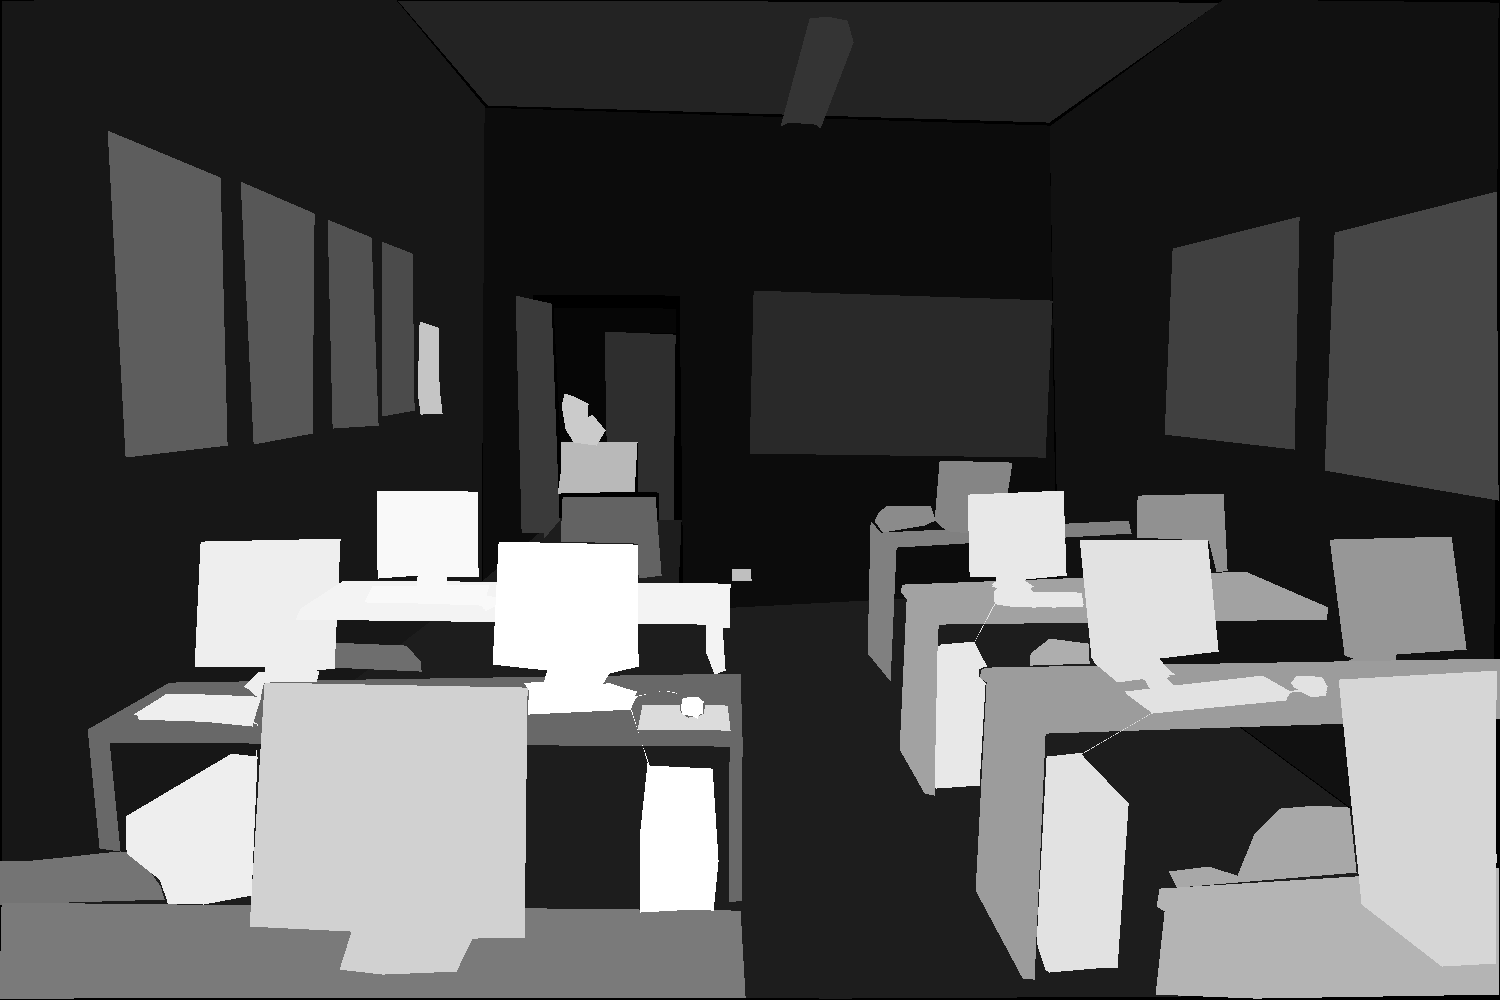

In [80]:
Image.fromarray(reshaped_b, mode='L')

In [159]:
summed_pixel_vals.shape

(1000, 1500)

In [157]:
def inspect_pixel(rgb_val):
    b_chan, g_chan, r_chan = rgb_val
    return b_chan

In [90]:
def find_objects(rgb_val):
    b_chan, g_chan, r_chan = rgb_val
    obj_id = b_chan.items()
    obj_class = g_chan.item() * r_chan.item()
    if obj_id not in found_objs:
        obj

In [158]:
found_objs = {}
obj_mask = np.apply_along_axis(inspect_pixel, 2, cv_mask)  

In [115]:
vals_seen = []
for pix_val in np.nditer(cv_mask, flags=['external_loop'], order='F'):
    vals_seen.append(pix_val)

In [ ]:
np.apply_over_axes(np.product, cv_mask, [2])

In [ ]:
np.apply_over_axes(in)

In [112]:
np.product(cv_mask.shape)

4500000

In [113]:
vals_seen[0].shape

(4500000,)

In [114]:
len(vals_seen)

1

In [186]:
pd.Series(pixel_obj_classes.flatten()).value_counts()

2978    580042
724     173846
976     153352
1583    138155
591     133850
447      73773
1499     72796
1969     63777
202      47640
471      19433
774      18386
0        16546
982       4810
1614      1966
1910      1398
2982       230
dtype: int64

In [177]:
obj_mask = cv_mask[::,::,0:1].reshape(cv_mask.shape[:2])
g_chan = cv_mask[::,::,1:2]
r_chan = cv_mask[::,::,2:3]

class_mask = r_chan.astype(int) / 10 * 256  +  g_chan.astype(int)
class_mask = pixel_obj_classes.astype(int)

In [174]:
# class_mask = r_chan = cv_mask[::,::,1:3]
# obj_mask = cv_mask[::,::,0:1].reshape(cv_mask.shape[:2])

In [223]:
def extract_objs_bboxes(label_array):
    obj_mask = label_array[::,::,0:1].reshape(label_array.shape[:2])
    g_chan = label_array[::,::,1:2]
    r_chan = label_array[::,::,2:3]
    class_mask = r_chan.astype(int) / 10 * 256  +  g_chan.astype(int)
    class_mask = pixel_obj_classes.astype(int)

    detections = defaultdict(dict)
    mask_iter = np.nditer(obj_mask, flags=['multi_index'])
    while not mask_iter.finished:
        pix_val = mask_iter[0].item()
        x_coord, y_coord = mask_iter.multi_index[:2]
        if pix_val not in detections:
            detections[pix_val]['objectClass'] = class_mask[x_coord][y_coord].item()
            detections[pix_val]['rectangle'] = [x_coord, y_coord] * 2
        else:
            x_min, y_min, x_max, y_max = detections[pix_val]['rectangle']
            if x_coord < x_min:
                detections[pix_val]['rectangle'][0] = x_coord
            if x_coord > x_max:
                detections[pix_val]['rectangle'][1] = x_coord
            if y_coord < y_min:
                detections[pix_val]['rectangle'][2] = y_coord
            if y_coord > y_max:
                detections[pix_val]['rectangle'][3] = y_coord
        mask_iter.iternext()
    return detections

In [224]:
det_test = extract_objs_bboxes(cv_mask)

In [225]:
det_test

defaultdict(dict,
            {0: {'objectClass': 0, 'rectangle': [0, 999, 998, 1499]},
             6: {'objectClass': 2978, 'rectangle': [308, 441, 308, 675]},
             12: {'objectClass': 2978, 'rectangle': [108, 607, 483, 1055]},
             17: {'objectClass': 2978, 'rectangle': [0, 1, 1221, 1498]},
             23: {'objectClass': 2978, 'rectangle': [0, 860, 32, 484]},
             29: {'objectClass': 976, 'rectangle': [518, 998, 851, 1358]},
             35: {'objectClass': 447, 'rectangle': [1, 122, 1, 1217]},
             41: {'objectClass': 202, 'rectangle': [291, 457, 291, 1052]},
             46: {'objectClass': 774, 'rectangle': [332, 519, 332, 675]},
             52: {'objectClass': 982, 'rectangle': [17, 18, 810, 853]},
             58: {'objectClass': 774, 'rectangle': [296, 537, 531, 559]},
             64: {'objectClass': 1499, 'rectangle': [217, 218, 1292, 1299]},
             70: {'objectClass': 1499, 'rectangle': [192, 193, 1489, 1498]},
             75: {'obj

# Build dataset scaffolding

In [221]:
def build_dataset():
    return

def build_object_entry(image_name, img_obj_df):
    
    objects = {}
    return objects

def build_image_entry(image_name, image_df):
    image_fields = {}
    
    image_row = image_df[image_df['filename'] == image_name]
    image_fields['imageName'] = image_name
    image_fields['scene'] = image_row['scene'].values[0]
    image_fields['setting'] = image_row['setting'].values[0]

    image_fields['objects'] = build_object_entry(image_name)
    
    return image_fields

In [ ]:
im

In [222]:
image_df.head()

,filename,folder,scene,setting
0,ADE_train_00000001.jpg,ADE20K_2016_07_26/images/training/a/airport_te...,airport_terminal,ambiguous
1,ADE_train_00000002.jpg,ADE20K_2016_07_26/images/training/a/airport_te...,airport_terminal,ambiguous
2,ADE_train_00000003.jpg,ADE20K_2016_07_26/images/training/a/art_gallery,art_gallery,ambiguous
3,ADE_train_00000004.jpg,ADE20K_2016_07_26/images/training/b/badlands,badlands,ambiguous
4,ADE_train_00000005.jpg,ADE20K_2016_07_26/images/training/b/ball_pit,ball_pit,ambiguous


In [223]:
timg= 'ADE_train_00005940.jpg'
build_image_entry(timg, image_df)

{'imageName': 'ADE_train_00005940.jpg',
 'objects': {},
 'scene': 'computer_room',
 'setting': 'indoor'}

In [216]:
image_df[image_df['filename'] == timg]['scene']

5939    computer_room
Name: scene, dtype: object

In [215]:
obj_df[obj_df['obj_class'] == sample_n]

,objectnames,objectcounts,proportionClassIsPart,wordnet_found,wordnet_level1,wordnet_synset,wordnet_hypernym,wordnet_gloss,wordnet_synonyms,wordnet_frequency,obj_class
2981,"wall socket, wall plug, electric outlet, elect...",1633,0,1,"wall socket, wall plug, electric outlet, elect...","wall socket, wall plug, electric outlet, elect...","[wall socket, wall plug, electric outlet, elec...",receptacle providing a place in a wiring syste...,"wall socket, wall plug, electric outlet, elect...",1,2982


# hide

In [ ]:
obj_cat = r_chan.tolist()
build_val_list = [item for sublist in obj_cat for item in sublist]

In [ ]:
# pd.Series([sc.split('/')[-1] for sc in ade_index.scene.tolist() if sc.split('/')[0] != sc.split('/')[-1]]).value_counts()

In [ ]:
# for qt, cats in q_cat_defs.items():
#     obj_count = obj_df[obj_df['objectnames'].isin(cats)].sum()[1]
#     print(qt, int(obj_count))